<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/explore_one_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import numpy as np
import matplotlib.pyplot as plt

In [103]:
# sigmoid activation with option to stretch and shift
def sigmoid(z,sig_param):

    _slope,_bias = sig_param

    return 1.0/(1.0+np.exp(-_slope*(z+_bias)))

In [104]:
# forward dynamics/discretization, euler integration
def euler_dyn(Z,t_,params_,alpha_params_):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S,h_start,R_start,t_start = params_


    # alpha frequency & amplitude
    _af,_aa,_ap = alpha_params_


    # initialize empty matrices
    dt = np.diff(t_)[0]
    dh1dt = (np.zeros((len(t_)+1,)))
    dR1dt = (np.zeros((len(t_)+1,)))
    dR1dt[0] = R_start;
    dZdt = (np.zeros((len(t_)+1,)))

    # alpha inhibition
    alpha_inh1 = _aa*np.sin(2*np.pi*_af*t_+_ap)+_aa

    boxcar = np.zeros(len(t_))
    boxcar[t_start:] = 1

    for _it,t in enumerate(t_):

        # pre-activation
        dZdt[_it+1] = (Z*boxcar[_it] + dh1dt[_it] - dR1dt[_it] - alpha_inh1[_it])/S

        # dynamics hidden layer1
        dh1dt[_it+1] = dh1dt[_it] + dt/tau_h * (-dh1dt[_it] + sigmoid(dZdt[_it+1],[2,-2.5]))

        # adaptation term 1
        dR1dt[_it+1] = dR1dt[_it] + dt/tau_R * (-dR1dt[_it] + c*dh1dt[_it+1])



    return dZdt, dh1dt, dR1dt

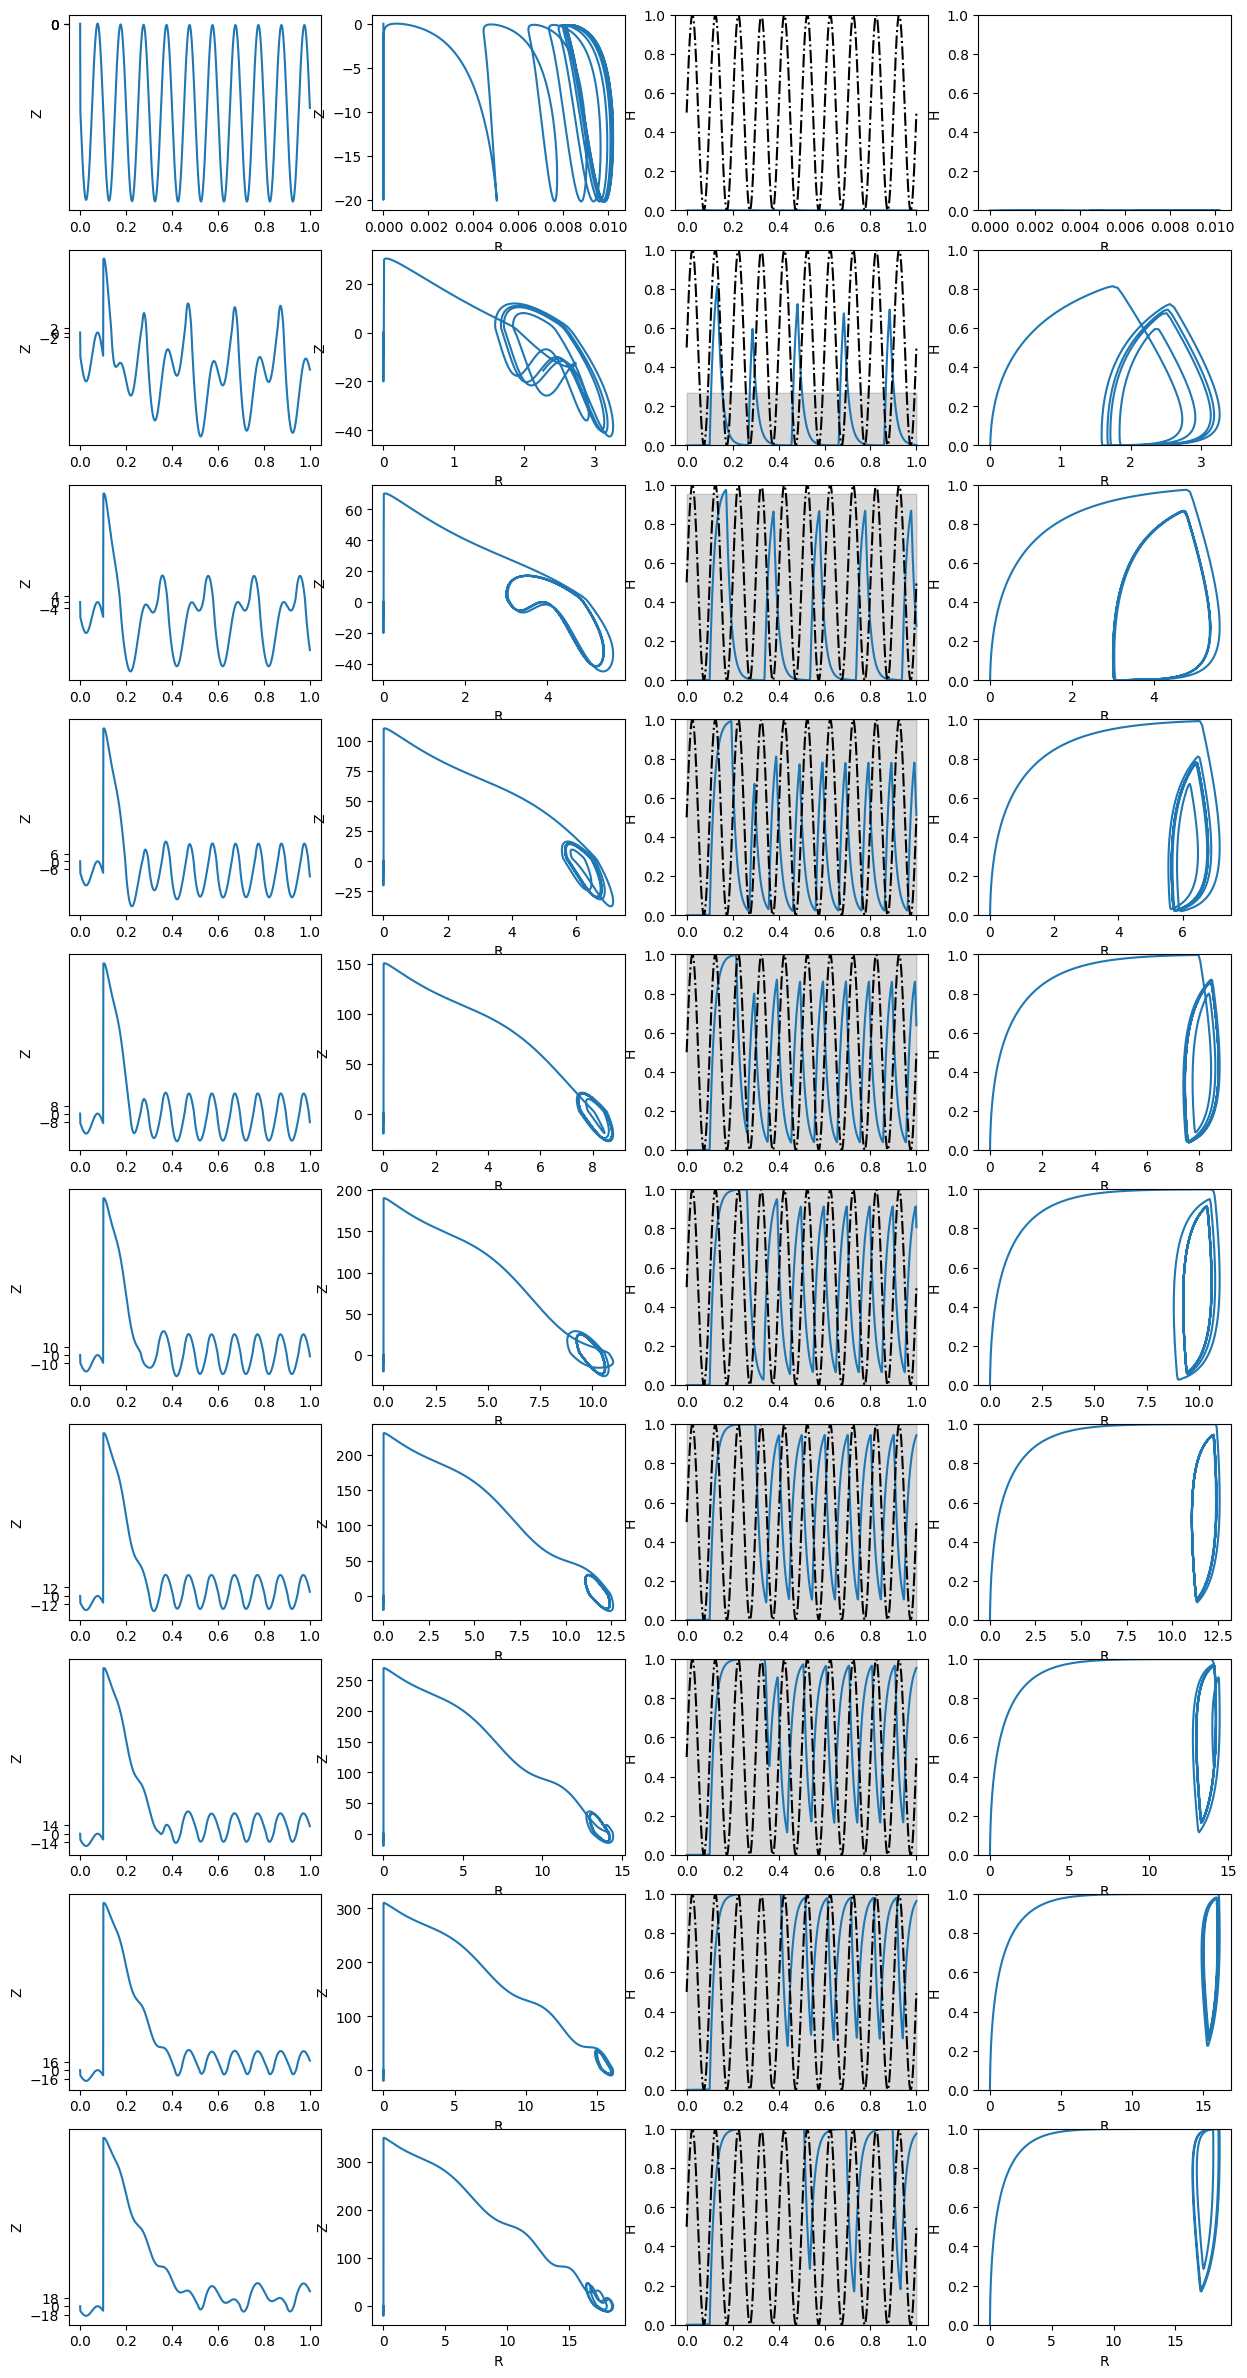

In [107]:
allZ = np.arange(0,20,2)

tau_h = 0.02
tau_R = 0.2
S = .05
h_start = 0
R_start = 0
c = 1.75*np.max(allZ)/1.5


fig, axs = plt.subplots(allZ.shape[0],4)

t_start = 100
t = 0
plt.rcParams["figure.figsize"] = (24,30)

for i,Z in enumerate(allZ):


  params = [tau_h,tau_R,c,S,h_start,R_start,t_start]

  afreq = 10
  aamp = 0.5
  aph = 0

  alpha_params = [afreq,aamp,aph]

  timevec = np.linspace(0,1,1000)

  Zt,Ht,Rt = euler_dyn(Z,timevec,params,alpha_params)


  axs[i,0].plot(timevec[t:],Zt[t:-1])
  axs[i,0].set_yticks((-Z,0,Z))
  axs[i,0].set_ylabel('Z')
  axs[i,1].plot(Rt[t:],Zt[t:])
  axs[i,1].set_xlabel('R')
  axs[i,1].set_ylabel('Z')

  axs[i,2].plot(timevec[t:],Ht[t:-1])

  if aamp:
    axs[i,2].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,2].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(sigmoid(Z,[2,-2.5]),timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,2].set_ylabel('H')

  axs[i,2].set_ylim(0,1)
  axs[i,3].plot(Rt[t:],Ht[t:])
  axs[i,3].set_ylim(0,1)
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('H')


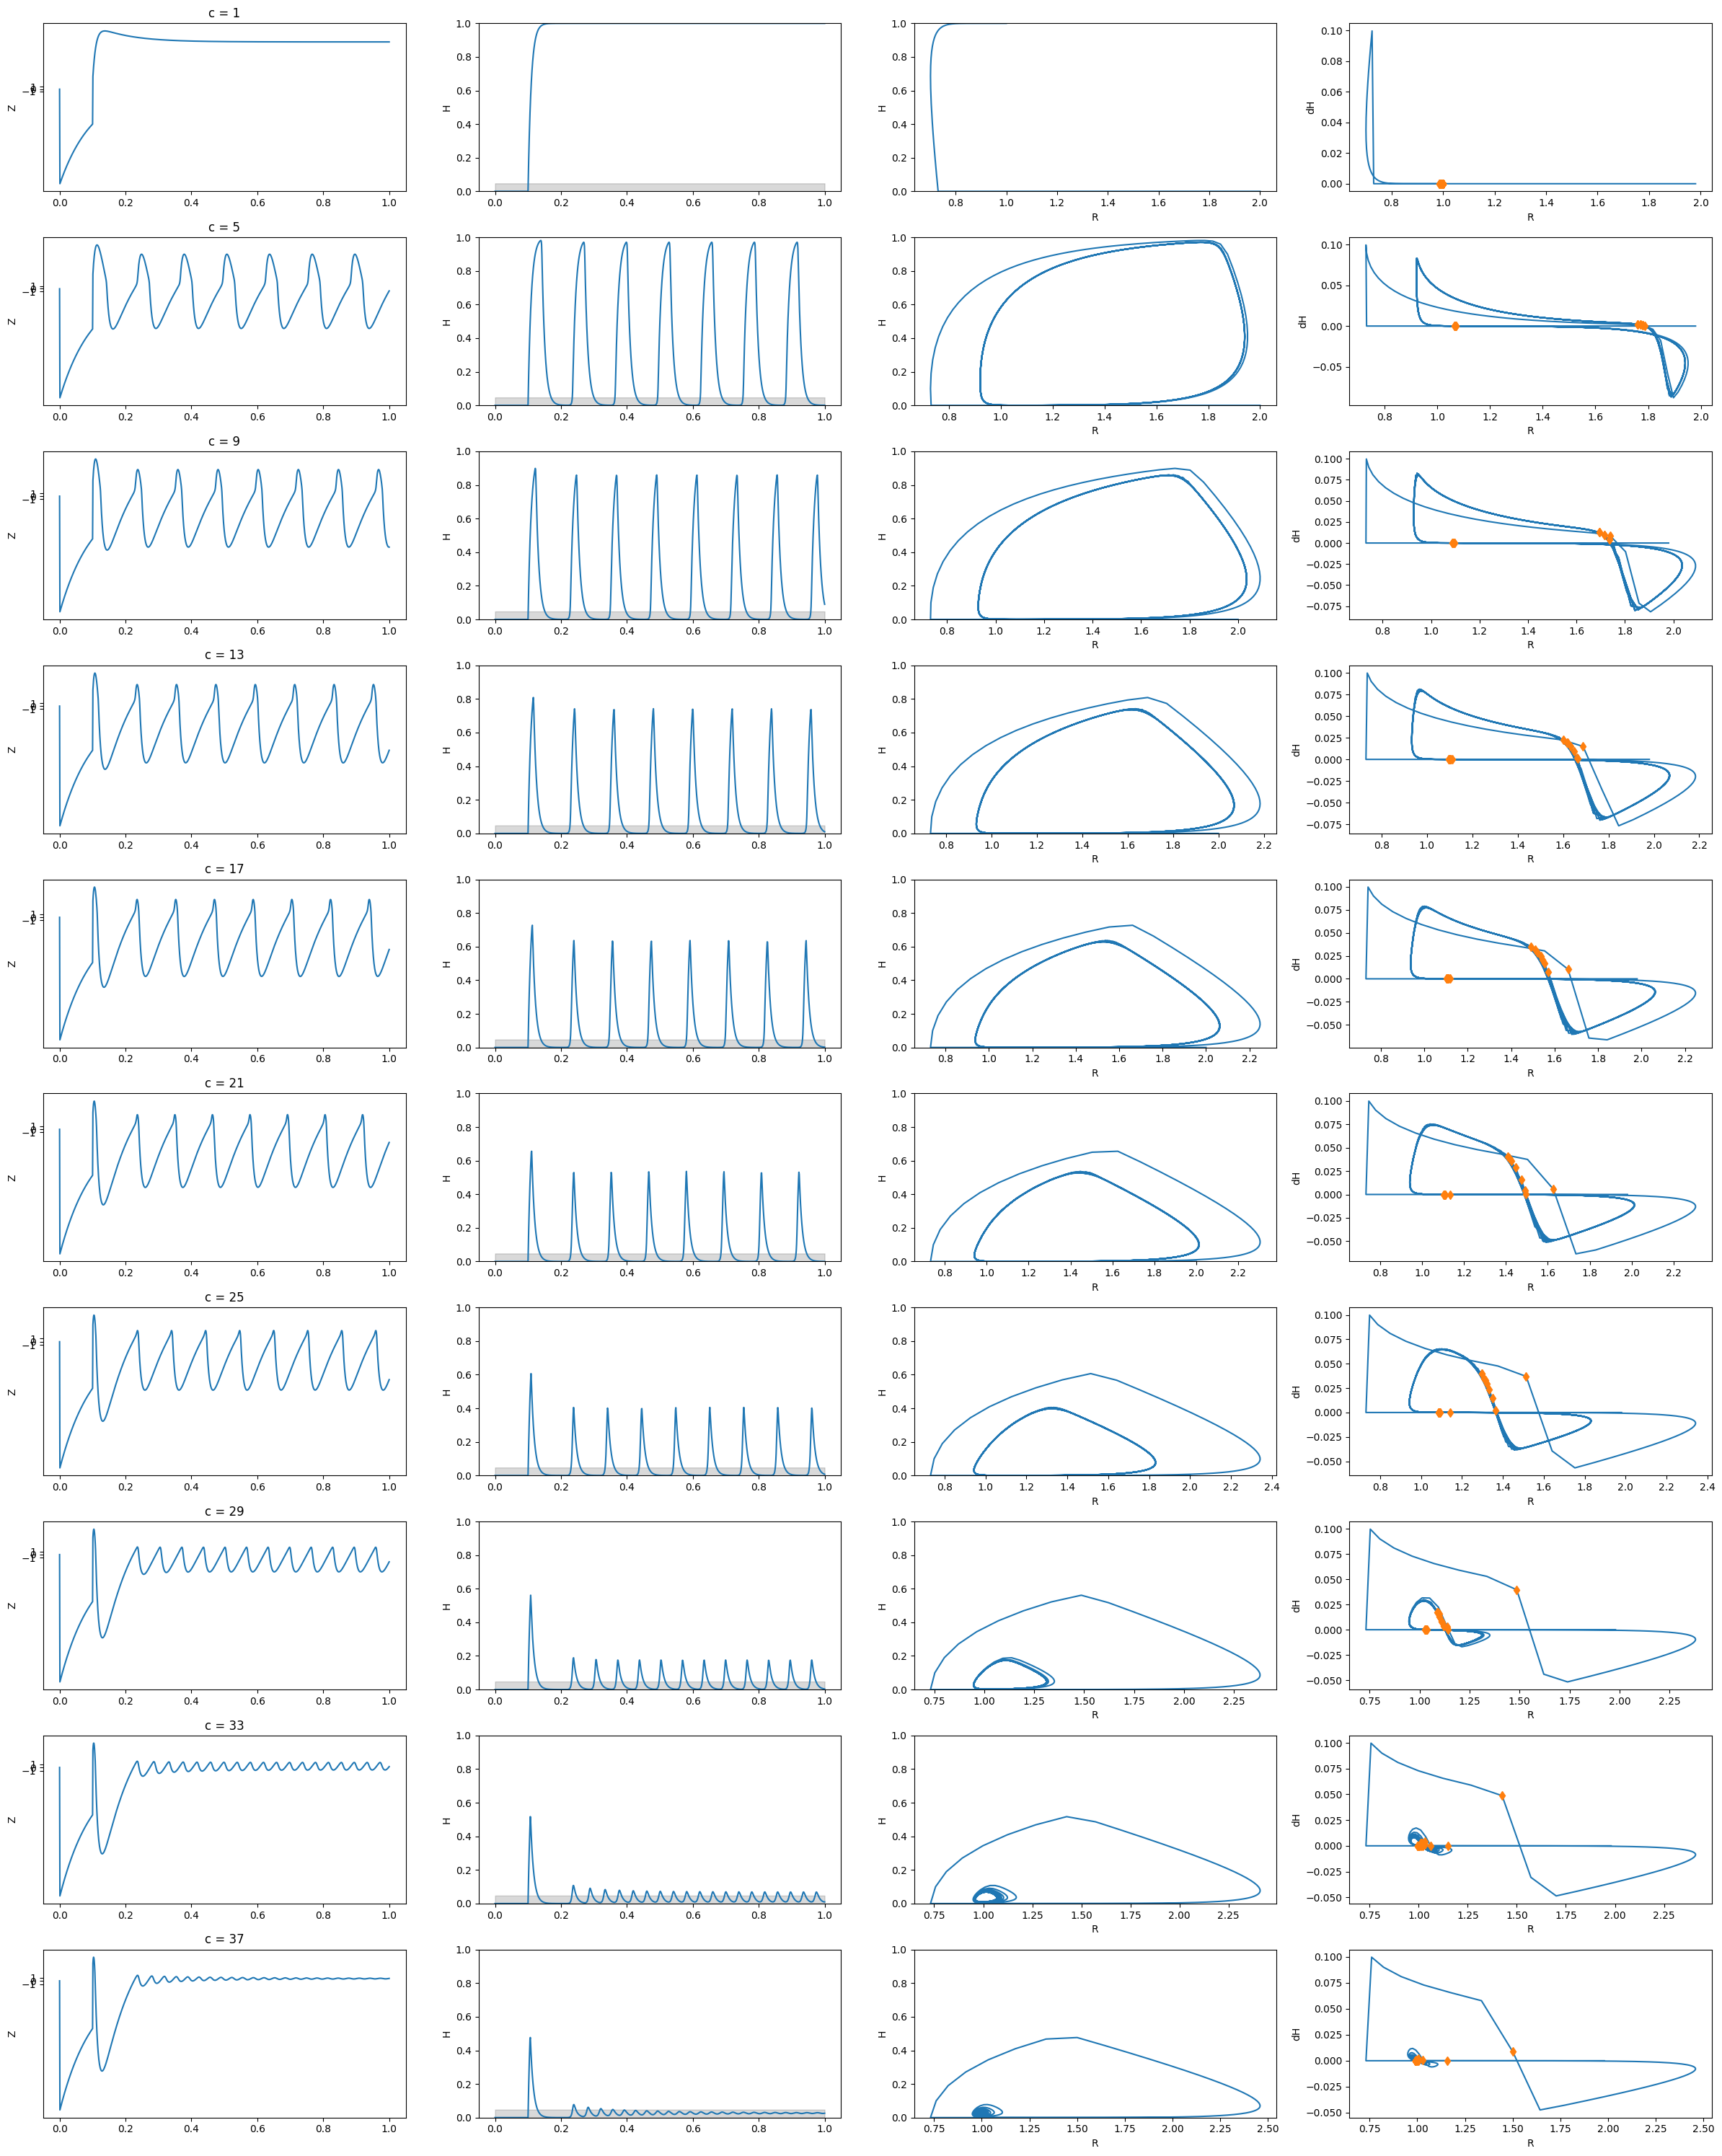

In [139]:
Z = 1

tau_h = 0.01
tau_R = 0.1
S = .05
h_start = 0
R_start = 2

tryC = np.arange(Z,Z*40,Z*4)

fig, axs = plt.subplots(tryC.shape[0],4)

t_start = 100
t = 0
plt.rcParams["figure.figsize"] = (24,30)

for i,c in enumerate(tryC):

  params = [tau_h,tau_R,c,S,h_start,R_start,t_start]

  afreq = 10
  aamp = 0
  aph = 0

  alpha_params = [afreq,aamp,aph]

  timevec = np.linspace(0,1,1000)

  Zt,Ht,Rt = euler_dyn(Z,timevec,params,alpha_params)


  axs[i,0].plot(timevec[t:],Zt[t:-1])
  axs[i,0].set_yticks((-Z,0,Z))
  axs[i,0].set_ylabel('Z')
  axs[i,0].set_title('c = '+str(c))
  axs[i,1].plot(timevec[t:],Ht[t:-1])

  if aamp:
    axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(sigmoid(Z,[2,-2.5]),timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')
  axs[i,1].set_ylim(0,1)


  axs[i,2].plot(Rt[t:],Ht[t:])
  axs[i,2].set_ylim(0,1)
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('H')

  dH = np.diff(Ht)

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(Rt[t+1:],dH)
  axs[i,3].plot(Rt[(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'d')
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('dH')

fig.tight_layout()


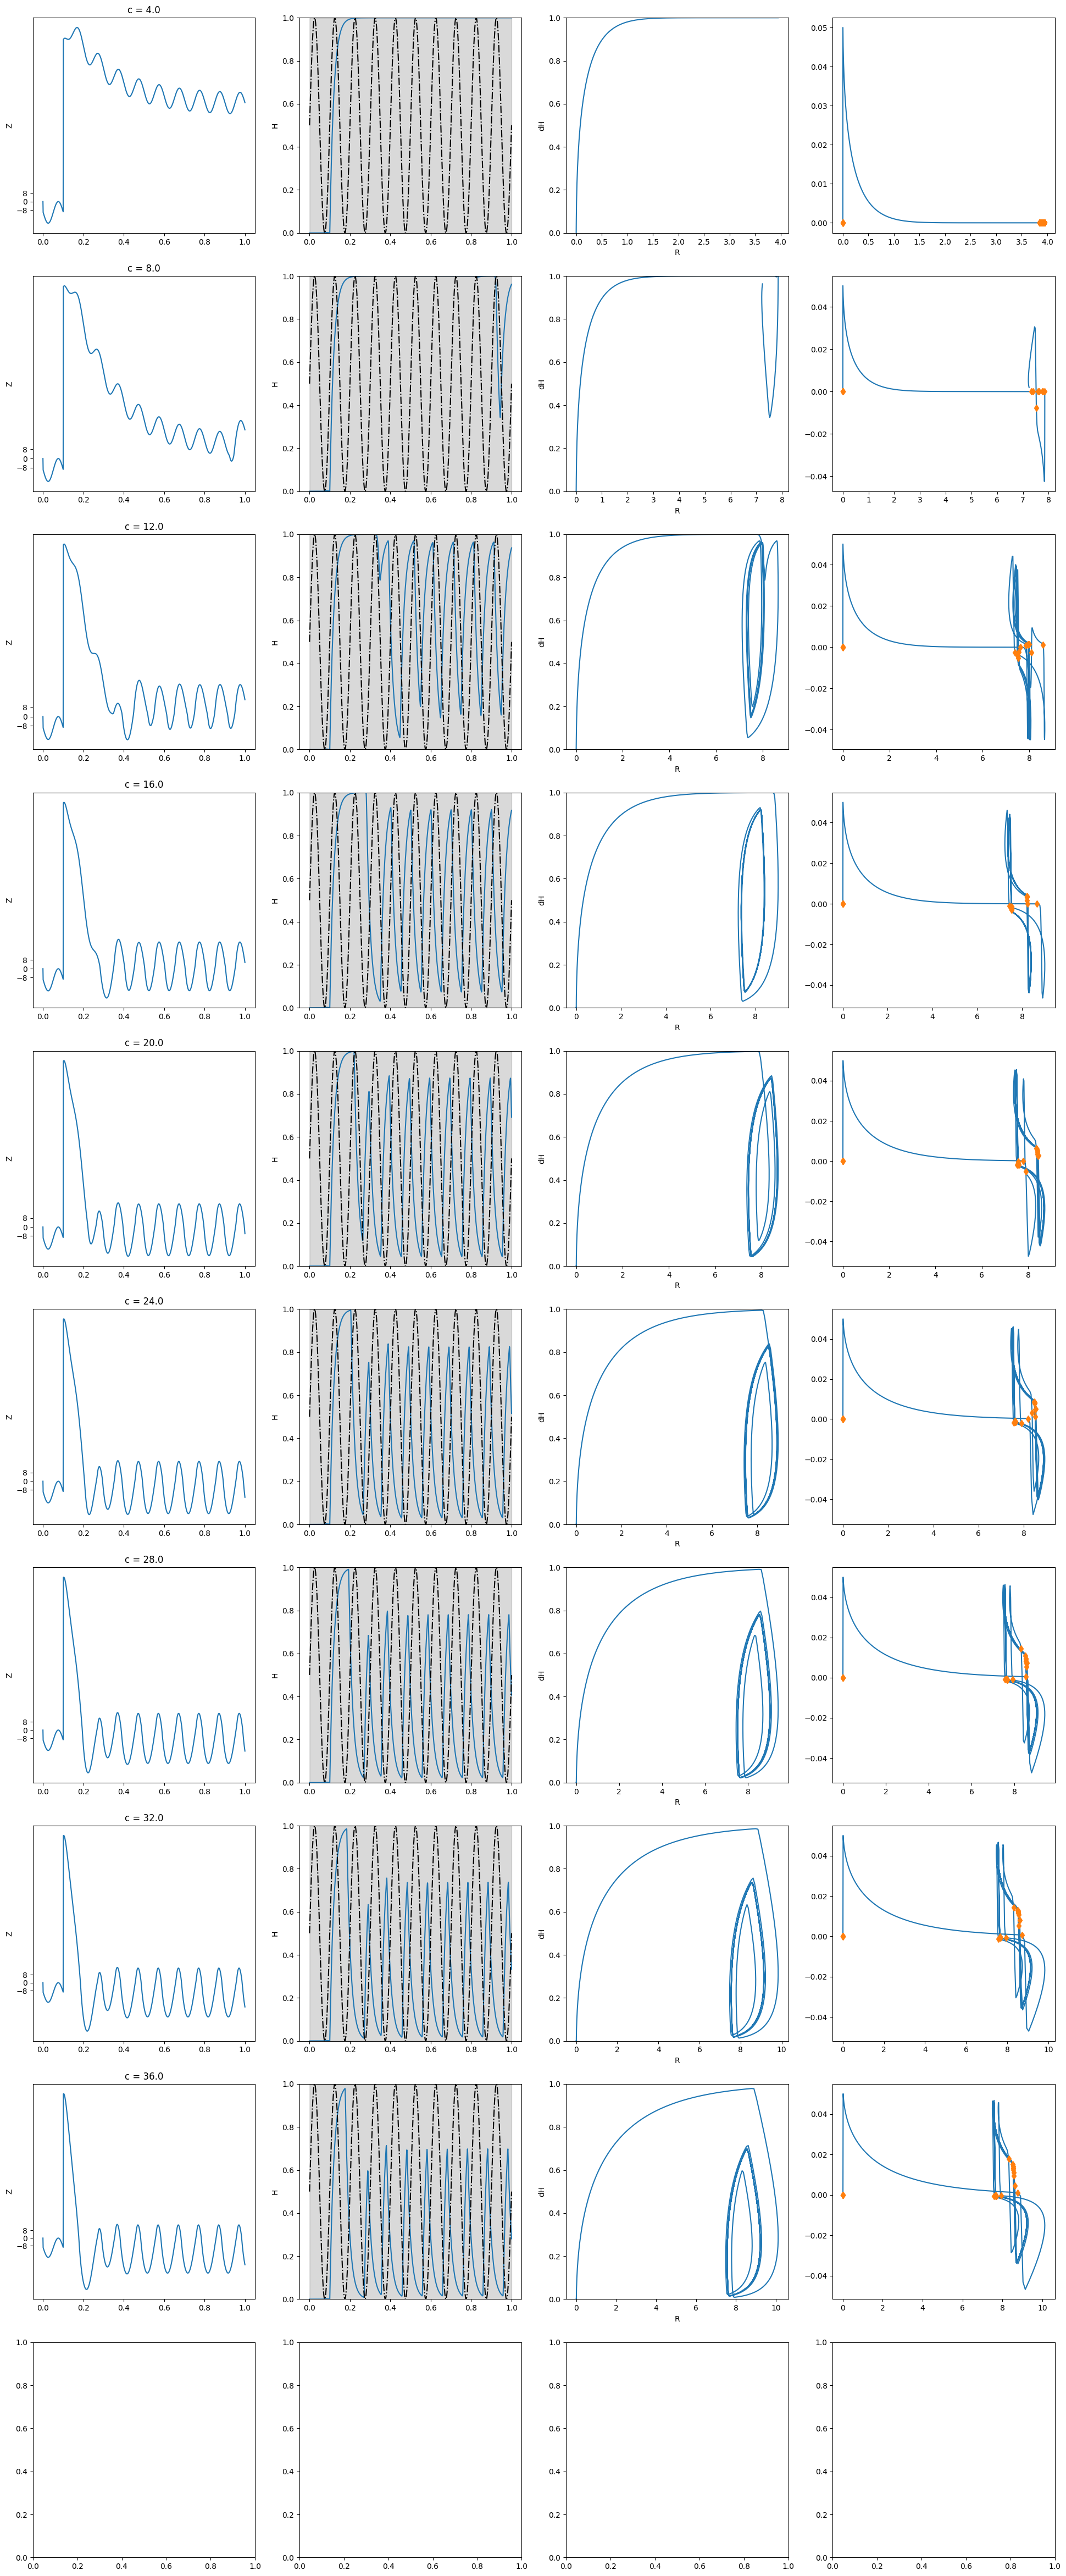

In [119]:
Z =8

tau_h = 0.02
tau_R = 0.2
S = .05
h_start = 0
R_start = 0

tryC = np.arange(Z/2,Z*5,Z/2)

fig, axs = plt.subplots(allZ.shape[0],4)

t_start = 100
t = 0
plt.rcParams["figure.figsize"] = (24,60)

for i,c in enumerate(tryC):

  params = [tau_h,tau_R,c,S,h_start,R_start,t_start]

  afreq = 10
  aamp = 0.5
  aph = 0

  alpha_params = [afreq,aamp,aph]

  timevec = np.linspace(0,1,1000)

  Zt,Ht,Rt = euler_dyn(Z,timevec,params,alpha_params)


  axs[i,0].plot(timevec[t:],Zt[t:-1])
  axs[i,0].set_yticks((-Z,0,Z))
  axs[i,0].set_ylabel('Z')
  axs[i,0].set_title('c = '+str(c))
  axs[i,1].plot(timevec[t:],Ht[t:-1])

  if aamp:
    axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(sigmoid(Z,[2,-2.5]),timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')
  axs[i,1].set_ylim(0,1)


  axs[i,2].plot(Rt[t:],Ht[t:])
  axs[i,2].set_ylim(0,1)
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('H')

  dH = np.diff(Ht)

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(Rt[t+1:],dH)
  axs[i,3].plot(Rt[(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'d')
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('dH')

In [114]:
mark_sign_chan

array([  2.,  45.,  80.,  99., 499., 535., 687., 727., 890., 929.])